# Project 5: Sentiment Analysis with Basic NLP
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Load Packages

In [2]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
import project_tests

from tqdm import tqdm

### Download NLP Corpora
You'll need two corpora to run this project: the stopwords corpus for removing stopwords and wordnet for lemmatizing.

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Get 10ks
We'll be running NLP anlalysis on 10-k documents. To do that, we first need to download the documents. For this project, we'll download 10-ks for Apple and Amazon. To lookup documents for these companies, we'll use their CIK.

In [4]:
cik_lookup = {'AMZN': '0000320193', 'AAPL': '0001018724'}

### Get list of 10-ks
Let's pull a list of filled 10-ks from the SEC for each company.

In [5]:
from bs4 import BeautifulSoup


def get_sec_data(cik, doc_type, start=0, count=10):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    page = project_helper.call_sec(rss_url)
    feed = BeautifulSoup(page.text.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]

    return entries

Let's pull the list using the `get_sec_data` function, then display some of the results. For displaying some of the data, we'll use Amazon as an example. 

In [6]:
example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('http://www.sec.gov/Archives/edgar/data/320193/000032019318000145/0000320193-18-000145-index.htm',
  '10-K',
  '2018-11-05'),
 ('http://www.sec.gov/Archives/edgar/data/320193/000032019317000070/0000320193-17-000070-index.htm',
  '10-K',
  '2017-11-03'),
 ('http://www.sec.gov/Archives/edgar/data/320193/000162828016020309/0001628280-16-020309-index.htm',
  '10-K',
  '2016-10-26'),
 ('http://www.sec.gov/Archives/edgar/data/320193/000119312515356351/0001193125-15-356351-index.htm',
  '10-K',
  '2015-10-28'),
 ('http://www.sec.gov/Archives/edgar/data/320193/000119312514383437/0001193125-14-383437-index.htm',
  '10-K',
  '2014-10-27')]


### Download 10-ks
As you see, this is a list of urls. These urls point to a file that contains meta data related to each filling. Since we don't care about the meta data, we'll pull the filling by replacing the url with the filling url.

In [7]:
raw_fillings_by_ticker = {}
for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = project_helper.call_sec(file_url).text


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0000320193-18-000145.txt : 20181105
<SEC-HEADER>0000320193-18-000145.hdr.sgml : 20181105
<ACCEPTANCE-DATETIME>20181105080140
ACCESSION NUMBER:		0000320193-18-000145
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		88
CONFORMED PERIOD OF REPORT:	20180929
FILED AS OF DATE:		20181105
DATE AS OF CHANGE:		20181105

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			APPLE INC
		CENTRAL INDEX KEY:			0000320193
		STANDARD INDUSTRIAL CLASSIFICATION:	ELECTRONIC COMPUTERS [3571]
		IRS NUMBER:				942404110
		STATE OF INCORPORATION:			CA
		FISCAL YEAR END:			0930

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-36743
		FILM NUMBER:		181158788

	BUSINESS ADDRESS:	
		STREET 1:		ONE APPLE PARK WAY
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014
		BUSINESS PHONE:		(408) 996-1010

	MAIL ADDRESS:	
		STREET 1:		ONE APPLE PARK WAY
		CITY:			CUPERTINO
		STATE:			CA
		ZIP:			95014

	FORMER COMPANY:	
		FORMER CONFORMED NAME:	APPLE COMPUT

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag inbetween.

Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [12]:
import re


def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    # TODO: Implement
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    
    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    document = []
    
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
        document.append(text[doc_start_i:doc_end_i])
    
    return document


project_tests.test_get_documents(get_documents)

Tests Passed


With the `get_documents` function implemented, let's extract all the documents.

In [13]:
filling_documents_by_ticker = {}
for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in raw_fillings.items():
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Document 0 Filed on 2018-11-05:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>a10-k20189292018.htm
<DESCRIPTION>10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<head>
		...

Document 1 Filed on 2018-11-05:

<TYPE>EX-10.17
<SEQUENCE>2
<FILENAME>a10-kexhibit10172018.htm
<DESCRIPTION>EXHIBIT 10.17
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
...

Document 2 Filed on 2018-11-05:

<TYPE>EX-10.18
<SEQUENCE>3
<FILENAME>a10-kexhibit10182018.htm
<DESCRIPTION>EXHIBIT 10.18
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
...


### Get Document Types
Not that we have all the documents, we want to find the 10-k form in this 10-k filling. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`.

In [22]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # TODO: Implement
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    doc_types = str([x[len('<TYPE>'):] for x in type_pattern.findall(doc)][0].lower())
    
    return doc_types


project_tests.test_get_document_type(get_document_type)

Tests Passed


With the `get_document_type` function, we'll filter out all non 10-k documents.

In [23]:
ten_ks_by_ticker = {}
for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a10-k2018929...
    file_date: '2018-11-05'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a10-k2017930...
    file_date: '2017-11-03'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>a201610-k924...
    file_date: '2016-10-26'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d17062d10k.h...
    file_date: '2015-10-28'},
  {
    cik: '0000320193'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>d783162d10k....
    file_date: '2014-10-27'},
]


### Get Items
Each 10-k form is broken into items. For this project, we want item 1a, 7, and 7a. We'll use the function `find_items` to extract the items from the document.

In [24]:
def find_items(ten_k):
    fin_pattern=re.compile(r'(>Item(\s|&#160;|&nbsp;|)[01]{0,1}[0-9][AB]{0,1}\.{0,1})|(ITEM\s[01]{0,1}[0-9][AB]{0,1})')
    fin_match=re.finditer(fin_pattern,(ten_k))
    
    test_df=pd.DataFrame([(x.group(),x.start(),x.end()) for x in (fin_match)])
    test_df.columns=['item','start','end']
    test_df['item']=test_df.item.str.lower()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace({'item': r'^>'}, {'item': ' '}, regex=True,inplace=True)
    
    pos_dat=test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'],keep='last')
    pos_dat.replace(' ','',regex=True,inplace=True)
    pos_dat.loc[:,('start_next')]=(pos_dat.start.shift(-1))
    pos_dat.start_next.replace(np.nan,len(ten_k),inplace=True)
    pos_dat.loc[:,('end')]=pos_dat.start_next.astype('int')
    pos_dat.drop(['start_next'],axis=1,inplace=True)
    fin_dat=pos_dat.set_index('item').T.to_dict('list')
    
    item1a=ten_k[fin_dat['item1a'][0]:fin_dat['item1a'][1]]
    item7=ten_k[fin_dat['item7'][0]:fin_dat['item7'][1]]
    item7a=ten_k[fin_dat['item7a'][0]:fin_dat['item7a'][1]]
    
    return item1a, item7, item7a

In [25]:
for _, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        item1a, item7, item7a = find_items(ten_k['file'])
        ten_k['item1a_raw'] = item1a
        ten_k['item7_raw'] = item7
        ten_k['item7a_raw'] = item7a


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['item1a_raw', 'item7_raw', 'item7a_raw'])

[
  {
    item1a_raw: '>Item 1A.</font></div></td><td style="vertical-al...
    item7_raw: '>Item 7.</font></div></td><td style="vertical-ali...
    item7a_raw: '>Item 7A.</font></div></td><td style="vertical-al...},
  {
    item1a_raw: '>Item 1A. </font></div></td><td style="vertical-a...
    item7_raw: '>Item 7. </font></div></td><td style="vertical-al...
    item7a_raw: '>Item 7A. </font></div></td><td style="vertical-a...},
  {
    item1a_raw: '>Item 1A. </font></div></td><td style="vertical-a...
    item7_raw: '>Item 7. </font></div></td><td style="vertical-al...
    item7a_raw: '>Item 7A. </font></div></td><td style="vertical-a...},
  {
    item1a_raw: '>Item&nbsp;1A.</B></TD>\n<TD ALIGN="left" VALIGN=...
    item7_raw: '>Item&nbsp;7.</B></TD>\n<TD ALIGN="left" VALIGN="...
    item7a_raw: '>Item&nbsp;7A.</B></TD>\n<TD ALIGN="left" VALIGN=...},
  {
    item1a_raw: '>Item&nbsp;1A.</B></TD>\n<TD ALIGN="left" VALIGN=...
    item7_raw: '>Item&nbsp;7.</B></TD>\n<TD ALIGN="left" VALIGN=

## Preprocess the Data
### Clean Up
As you can see, the text for the items is very messy. To clean this up, we'll remove the html and lowercase all the text.

In [26]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

Using the `clean_text` function, we'll clean up all the items.

In [27]:
for _, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        ten_k['item1a'] = clean_text(ten_k['item1a_raw'])
        ten_k['item7'] = clean_text(ten_k['item7_raw'])
        ten_k['item7a'] = clean_text(ten_k['item7a_raw'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['item1a', 'item7', 'item7a'])

[
  {
    item1a: '>item 1a.risk factorsthe following discussion of ...
    item7: '>item 7.management’s discussion and analysis of f...
    item7a: '>item 7a.quantitative and qualitative disclosures...},
  {
    item1a: '>item 1a. risk factorsthe following discussion of...
    item7: '>item 7. management’s discussion and analysis of ...
    item7a: '>item 7a. quantitative and qualitative disclosure...},
  {
    item1a: '>item 1a. risk factorsthe following discussion of...
    item7: '>item 7. management’s discussion and analysis of ...
    item7a: '>item 7a. quantitative and qualitative disclosure...},
  {
    item1a: '>item 1a.\nrisk factors  the following discussion...
    item7: '>item 7.\nmanagements discussion and analysis of...
    item7a: '>item 7a.\nquantitative and qualitative disclosur...},
  {
    item1a: '>item 1a.\nrisk factors  the following discussion...
    item7: '>item 7.\nmanagements discussion and analysis of...
    item7a: '>item 7a.\nquantitative and qualitativ

### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmitize verbs in the list of words provided.

In [34]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    # TODO: Implement
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
    
    return lemmatized_words


project_tests.test_lemmatize_words(lemmatize_words)

words:  ['cow', 'running', 'jeep', 'swimmers', 'tackle', 'throw', 'driven']
Tests Passed


With the `lemmatize_words` function implemented, let's lemmatize all the item data.

In [35]:
word_pattern = re.compile('\w+')


for _, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        ten_k['lemma_item1a'] = lemmatize_words(word_pattern.findall(ten_k['item1a']))
        ten_k['lemma_item7'] = lemmatize_words(word_pattern.findall(ten_k['item7']))  
        ten_k['lemma_item7a'] = lemmatize_words(word_pattern.findall(ten_k['item7a']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['lemma_item1a', 'lemma_item7', 'lemma_item7a'])

words:  ['item', '1a', 'risk', 'factorsthe', 'following', 'discussion', 'of', 'risk', 'factors', 'contains', 'forward', 'looking', 'statements', 'these', 'risk', 'factors', 'may', 'be', 'important', 'to', 'understanding', 'other', 'statements', 'in', 'this', 'form', '10', 'k', 'the', 'following', 'information', 'should', 'be', 'read', 'in', 'conjunction', 'with', 'part', 'ii', 'item', '7', 'management', 's', 'discussion', 'and', 'analysis', 'of', 'financial', 'condition', 'and', 'results', 'of', 'operations', 'and', 'the', 'consolidated', 'financial', 'statements', 'and', 'related', 'notes', 'in', 'part', 'ii', 'item', '8', 'financial', 'statements', 'and', 'supplementary', 'data', 'of', 'this', 'form', '10', 'k', 'the', 'business', 'financial', 'condition', 'and', 'operating', 'results', 'of', 'the', 'company', 'can', 'be', 'affected', 'by', 'a', 'number', 'of', 'factors', 'whether', 'currently', 'known', 'or', 'unknown', 'including', 'but', 'not', 'limited', 'to', 'those', 'described

# Analysis on 10ks
## Bag of Words
Let's extract some features from the text data using bag of words. Implement the `get_bag_of_words` using sklearn's `CountVectorizer` function.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(docs):
    """
    Generate a bag of words from documents

    Parameters
    ----------
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray
        Bag of words from the documents
    """
    
    # TODO: Implement
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(docs)
    
    return bag_of_words.toarray()


project_tests.test_get_bag_of_words(get_bag_of_words)

Tests Passed


Time to generate the bag of words for each item corpus.

In [38]:
bag_of_words_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    bag_of_words_ten_ks[ticker] = {
        'item1a': get_bag_of_words([' '.join(ten_k['lemma_item1a']) for ten_k in ten_ks]),
        'item7': get_bag_of_words([' '.join(ten_k['lemma_item7']) for ten_k in ten_ks]),
        'item7a': get_bag_of_words([' '.join(ten_k['lemma_item7a']) for ten_k in ten_ks])}


project_helper.print_ten_k_data([bag_of_words_ten_ks[example_ticker]], ['item1a', 'item7', 'item7a'])

[
  {
    item1a: '[[12  1  0 ...,  0  1  1]\n [10  1  0 ...,  0  1 ...
    item7: '[[0 0 0 ..., 1 0 0]\n [7 1 0 ..., 1 0 0]\n [6 0 0...
    item7a: '[[3 3 1 ..., 4 0 1]\n [3 3 0 ..., 4 0 1]\n [3 3 0...},
]


## Jaccard Similarity
Using the bag of words, let's calculate the jaccard similarty and plot it over time.

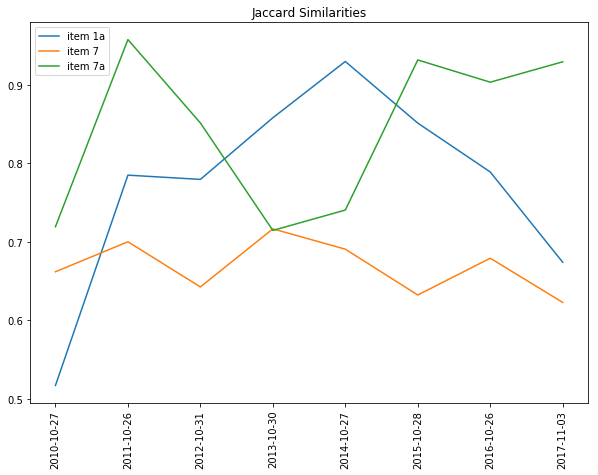

In [39]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(docs):
    similarites = []
    for doc_i in range(len(docs) - 1):
        similarites.append(jaccard_similarity_score(docs[doc_i], docs[doc_i + 1]))
    
    return similarites


# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

item_1a_jaccard_similarities = get_jaccard_similarity(bag_of_words_ten_ks[example_ticker]['item1a'])
item_7_jaccard_similarities = get_jaccard_similarity(bag_of_words_ten_ks[example_ticker]['item7'])
item_7a_jaccard_similarities = get_jaccard_similarity(bag_of_words_ten_ks[example_ticker]['item7a'])


project_helper.plot_similarities(
    [item_1a_jaccard_similarities, item_7_jaccard_similarities, item_7a_jaccard_similarities],
    file_dates[example_ticker][1:],
    'Jaccard Similarities',
    ['item 1a', 'item 7', 'item 7a'])

## Word Frequency
Just like we did with the bag of words, lets create TFIDF values.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer


def word_freq(docs):
    return TfidfVectorizer().fit_transform(docs).toarray()


word_freq_ten_ks = {}
for ticker, ten_ks in ten_ks_by_ticker.items():
    word_freq_ten_ks[ticker] = {
        'item1a': word_freq([' '.join(ten_k['lemma_item1a']) for ten_k in ten_ks]),
        'item7': word_freq([' '.join(ten_k['lemma_item7']) for ten_k in ten_ks]),
        'item7a': word_freq([' '.join(ten_k['lemma_item7a']) for ten_k in ten_ks])}


project_helper.print_ten_k_data([word_freq_ten_ks[example_ticker]], ['item1a', 'item7', 'item7a'])

[
  {
    item1a: '[[ 0.01292392  0.00206383  0.         ...,  0.   ...
    item7: '[[ 0.          0.          0.         ...,  0.001...
    item7a: '[[ 0.03359019  0.022233    0.01933855 ...,  0.029...},
]


## Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time.

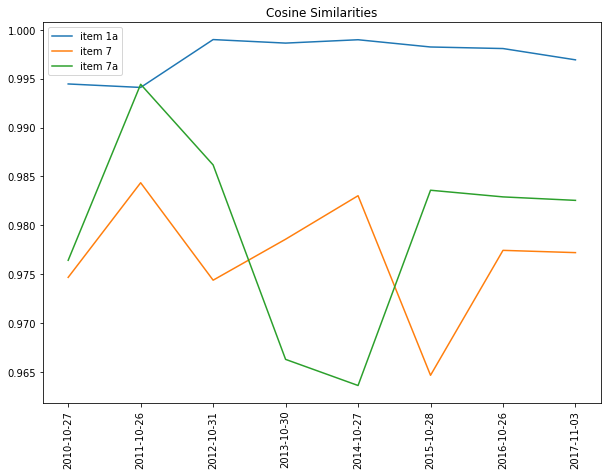

In [41]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(docs):
    return np.diag(cosine_similarity(docs, docs), k=1)


item_1a_cosine_similarities = get_cosine_similarity(word_freq_ten_ks[example_ticker]['item1a'])
item_7_cosine_similarities = get_cosine_similarity(word_freq_ten_ks[example_ticker]['item7'])
item_7a_cosine_similarities = get_cosine_similarity(word_freq_ten_ks[example_ticker]['item7a'])


project_helper.plot_similarities(
    [item_1a_cosine_similarities, item_7_cosine_similarities, item_7a_cosine_similarities],
    file_dates[example_ticker][1:],
    'Cosine Similarities',
    ['item 1a', 'item 7', 'item 7a'])

That's it! You've sucessfully done dentiment analysis on 10-ks!